# Decode stimuli from neural activity - across multiple sessions

In [5]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import time
import pickle

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib notebook

In [3]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-17_11-39-17_646318\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-18_10-44-55_646318\processed",
    r"Y:\2023-02-27_08-14-30_649944\processed",
    r"Y:\2023-02-28_09-33-43_649944\processed",    
]

modality = ['vis','vis','aud','vis','aud','aud','vis','vis','aud','aud','aud','aud']
mouseIDs = ['620263','620263','620264','628801','636397','636397','644547','644547','646318','646318','649944','649944']
exp_nums = [1,2, 1, 1, 1,2, 1,2, 1,2, 1,2]

## Loop through sessions

In [ ]:
start_time=time.time()

svc_results={}

binsize=0.25
# trial_number=[5,10,15,20,30,40,50]
trial_number=['all']
# trial_number=[90]
n_repeats=100
# n_units=[1,2,5,10,25,50]
n_units=['all']
time_bins=np.arange(-0.25,0.6,binsize)

svc_params={}
svc_params['trial_number']=trial_number
svc_params['n_repeats']=n_repeats
svc_params['n_units']=n_units
svc_params['time_bins']=time_bins
svc_params['binsize']=binsize

# session_idx=np.arange(0,len(main_path))
# main_path=np.asarray(main_path)

# sel_session_rerun=np.asarray([6,7,10,11]).astype(int)

for sel_session, path in enumerate(main_path):
# for sel_session, path in zip(session_idx[sel_session_rerun],main_path[sel_session_rerun]):
    
    svc_results[sel_session]={}
    svc_results[sel_session]['modality']=modality[sel_session]
    svc_results[sel_session]['mouse']=mouseIDs[sel_session]
    svc_results[sel_session]['exp_num']=exp_nums[sel_session]
    svc_results[sel_session]['results']={}
    
    print(path+' ... processing')
    session=Session(path=path) 
    session.assign_unit_areas()
    ## add areas
    
    # loop through sessions and make unit xarrays
    time_before_flash = 0.5
    trial_duration = 2
    bin_size = 0.001


    # Make tensor (3-D matrix [units,time,trials])
    trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                                  session.trials,time_before_flash, trial_duration, 
                                                  bin_size)

    # make xarray
    session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                               coords={
                                   "unit_id": session.good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "trials": session.trials.index.values
                                   })
    
    # grab data: make these [trials,neurons] matrices based on different time bins:
    # only include irrelevant stimuli?
    if modality[sel_session]=='vis':
        trial_sel=session.trials.query('trialStimID.str.contains("sound")').index
        area_sel=['AUD']
    elif modality[sel_session]=='aud':
        trial_sel=session.trials.query('trialStimID.str.contains("vis")').index
        area_sel=['VIS']

    # grab the stimulus ids
    stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)

    pred_var = stim_ids
    
    for aa in area_sel:
        if aa=='PFC':
            unit_sel = session.good_units.query('area.str.contains("ORB|PL|ILA|MOs|ACA")').index.values
        else:
            unit_sel = session.good_units.query('area.str.contains(@aa)').index.values
        
        svc_results[sel_session]['results'][aa]={}
        svc_results[sel_session][aa+'_n_units']=len(unit_sel)
        
        if len(unit_sel)==0:
            break
        
        for tridx,trnum in enumerate(trial_number):
            svc_results[sel_session]['results'][aa][tridx]={}
            for tt,t_start in enumerate(time_bins[:-1]):
                svc_results[sel_session]['results'][aa][tridx][tt]={}
                for u_idx,u_num in enumerate(n_units):  
                    svc_results[sel_session]['results'][aa][tridx][tt][u_idx]={}
                    for nn in range(0,n_repeats):
                        
                        #choose n units
                        if u_num=='all':
                            u_num=len(unit_sel)
                        if len(unit_sel)<u_num:
                            break
                        
                        unit_subset = np.random.choice(unit_sel,u_num,replace=False)

                        ### make sure equal # of trials per condition!
                        subset_ind=[]
                        conds = np.unique(pred_var)
                        cond_count=[]
                        
                        if trnum=='all':
                            for cc in conds:
                                cond_count.append(np.sum(pred_var==cc))
                            trnum=np.min(cond_count)
                        
                        for cc in conds:
                            cond_inds=np.where(pred_var==cc)[0]
                            subset_ind.append(np.random.choice(cond_inds,trnum,replace=False))   
                        subset_ind=np.sort(np.hstack(subset_ind))

                        sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                                        trials=trial_sel[subset_ind],
                                                        unit_id=unit_subset).mean(dim='time').values

                        X = sel_data.T
                        y = pred_var[subset_ind].flatten()

                        xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, stratify=y)

                        clf = svm.LinearSVC()
                        clf.fit(xtrain, ytrain)

                        ypred = clf.predict(xtest)

                        cr_dict=classification_report(ytest, ypred, output_dict=True)
                        cr_df=pd.DataFrame.from_dict(cr_dict)

                        svc_results[sel_session]['results'][aa][tridx][tt][u_idx][nn]=cr_df

                        
    elapsed_t=time.time()-start_time
    print(' ... done '+str(np.round(elapsed_t))+' sec')

## reformat classifier results for convenience

In [13]:
# make into more plottable format

####change this to deal with multiple #s of trials and average over re-runs of the SVC

plot_results={}

timepoints=svc_params['time_bins'][1:]

label_list=['vis1','vis2','sound1','sound2','True','False']

areas=['VIS','AUD']

for sel_session, path in enumerate(main_path):
    plot_results[sel_session]={}
    for aa in areas:
        plot_results[sel_session][aa]={}
        for ll in label_list:
            plot_results[sel_session][aa][ll]={}
            for tt,tp in enumerate(timepoints):
                plot_results[sel_session][aa][ll][tt]=np.zeros((len(svc_params['trial_number']),
                                                                len(svc_params['n_units']),
                                                                svc_params['n_repeats']))
                plot_results[sel_session][aa][ll][tt][:]=np.nan

    
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

decoder_acc_session_mean = {}
for tt,tp in enumerate(timepoints):
    decoder_acc_session_mean[tt]=np.zeros((len(svc_params['trial_number']),
                                            len(svc_params['n_units']),
                                            svc_params['n_repeats']))
    decoder_acc_session_mean[tt][:]=np.nan

for sel_session, path in enumerate(main_path):
    if modality[sel_session]=='vis':
        area_sel=['AUD']
        sel_stim=['sound1','sound2']
        irrel='aud'
    elif modality[sel_session]=='aud':
        area_sel=['VIS']
        sel_stim=['vis1','vis2']
        irrel='vis'
    for aa in area_sel: 
        if aa in svc_results[sel_session]['results'].keys():
            for tt,tp in enumerate(timepoints):
                for tridx,trnum in enumerate(svc_params['trial_number']):
                    for u_idx,u_num in enumerate(svc_params['n_units']):
                        
                            for nn in range(0,svc_params['n_repeats']):
                                for ll in label_list:
                                    if len(svc_results[sel_session]['results'][aa])>0:
                                        if len(svc_results[sel_session]['results'][aa][tridx][tt][u_idx])>0:
                                            if ll in svc_results[sel_session]['results'][aa][tridx][tt][u_idx][nn].keys():
                                                temp_perf=np.nanmean(svc_results[sel_session]['results']
                                                                  [aa][tridx][tt][u_idx][nn][ll]
                                                                  [['precision','recall']].values)
                                                plot_results[sel_session][aa][ll][tt][tridx,u_idx,nn]=temp_perf
                
                if len(svc_results[sel_session]['results'][aa])>0:                    
                    concat_results = np.concatenate((plot_results[sel_session][area_sel[0]][sel_stim[0]][tt],
                                                     plot_results[sel_session][area_sel[0]][sel_stim[1]][tt]),
                                                    axis=2)
                    decoder_acc_mean = np.nanmean(concat_results,2)
                    decoder_acc_session_mean[tt][:,:,sel_session] = decoder_acc_mean
    
    
# plot_results[area][label/stimulus][timepoint_idx][ntrials_idx,nunits_idx,n_repeats]

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16956\1527815890.py:66: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(concat_results,2)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16956\1527815890.py:66: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(concat_results,2)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16956\1527815890.py:66: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(concat_results,2)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16956\1527815890.py:66: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(concat_results,2)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16956\1527815890.py:66: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(concat_results,2)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16956\1527815890.py:66: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(concat_results,2)
C:\Users\ethan.mcbride\AppDa

In [14]:
# svc_results[11]['results']
# len(decoder_acc_session_mean[0])

In [16]:
#save results

savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\templeton decoding results'

with open(os.path.join(savepath,'decoder_results_250ms_wo_replace.pkl'), 'wb') as handle:
    pickle.dump(svc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(savepath,'decoder_params_250ms_wo_replace.pkl'), 'wb') as handle:
    pickle.dump(svc_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
np.save(os.path.join(savepath,'decoder_accuracy_across_sessions_250ms_wo_replace.npy'),
        decoder_acc_session_mean,allow_pickle=True)

In [6]:
# load results

savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\templeton decoding results'

with open(os.path.join(savepath,'decoder_results_250ms_wo_replace.pkl'), 'rb') as handle:
    svc_results = pickle.load(handle)
    
with open(os.path.join(savepath,'decoder_params_250ms_wo_replace.pkl'), 'rb') as handle:
    svc_params = pickle.load(handle)

decoder_acc_session_mean = np.load(os.path.join(savepath,'decoder_accuracy_across_sessions_250ms_wo_replace.npy'),
                                  allow_pickle=True)

In [15]:
# svc_params

## plot results

In [17]:
incl_sessions=[2,3,6,7,8,9,10,11]

<IPython.core.display.Javascript object>


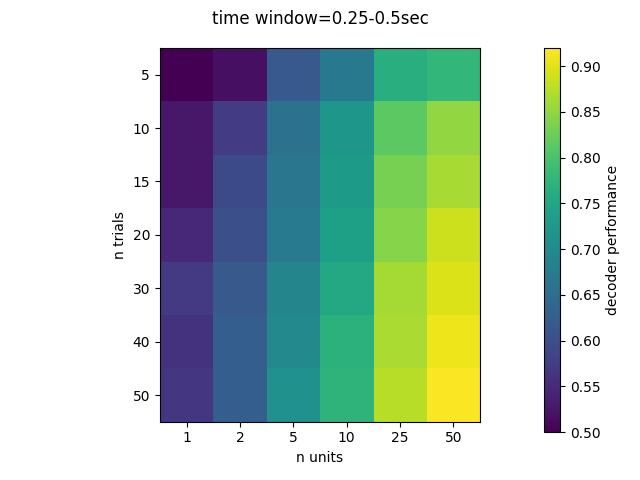

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16956\851757630.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [19]:
sel_t_point=3

fig,ax=plt.subplots(1,1)

im=ax.imshow(np.nanmean(decoder_acc_session_mean[sel_t_point][:,:,incl_sessions],2),vmax=0.92,vmin=0.5)
ax.set_xlabel('n units')
ax.set_xticks(np.arange(0,len(svc_params['n_units'])))
ax.set_xticklabels(svc_params['n_units'])

ax.set_ylabel('n trials')
ax.set_yticks(np.arange(0,len(svc_params['trial_number'])))
ax.set_yticklabels(svc_params['trial_number'])

# this adjusts the other plots to make space for the colorbar
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3) 
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('decoder performance')

#specify time point used
fig.suptitle('time window='+str(svc_params['time_bins'][sel_t_point])+
             '-'+str(svc_params['time_bins'][sel_t_point+1])+'sec')

fig.tight_layout()

In [ ]:
svc_params['n_units']

In [ ]:
time_bins

In [21]:
session_not_nan=~np.isnan(decoder_acc_session_mean[3][0,0,:])
mouseIDs=np.asarray(mouseIDs)

<IPython.core.display.Javascript object>


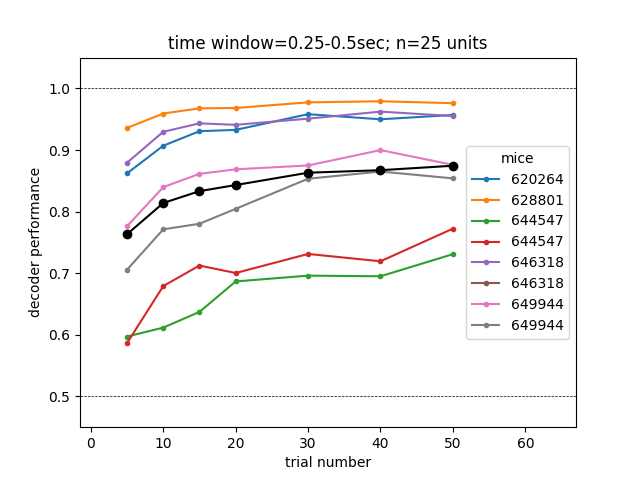

Text(0.5, 1.0, 'time window=0.25-0.5sec; n=25 units')

In [22]:
sel_t_point=3
sel_n_units=4

fig,ax=plt.subplots(1,1)

for xx in incl_sessions:
    ax.plot(svc_params['trial_number'],decoder_acc_session_mean[sel_t_point][:,sel_n_units,xx],'.-')
    
ax.plot(svc_params['trial_number'],np.nanmean(decoder_acc_session_mean[sel_t_point][:,sel_n_units,incl_sessions],1),'ko-')

ax.axhline(0.5,color='k',linestyle='--',linewidth=0.5)
ax.axhline(1,color='k',linestyle='--',linewidth=0.5)

ax.set_xlabel('trial number')
ax.set_xlim([-1.5,svc_params['trial_number'][-1]+17])
ax.set_ylabel('decoder performance')
ax.set_ylim([0.45,1.05])
ax.legend(mouseIDs[incl_sessions],title='mice')

ax.set_title('time window='+str(svc_params['time_bins'][sel_t_point])+
             '-'+str(svc_params['time_bins'][sel_t_point+1])+
             'sec; n='+str(svc_params['n_units'][sel_n_units])+' units')

<IPython.core.display.Javascript object>


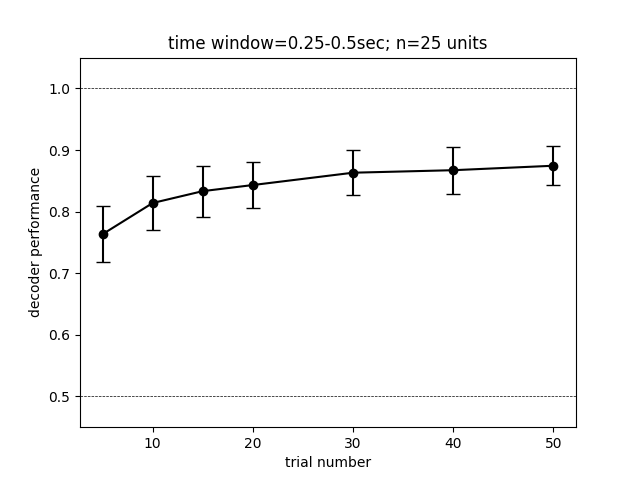

Text(0.5, 1.0, 'time window=0.25-0.5sec; n=25 units')

In [23]:
# avg & SEM only

sel_t_point=3
sel_n_units=4

fig,ax=plt.subplots(1,1)

yvals=np.nanmean(decoder_acc_session_mean[sel_t_point][:,sel_n_units,incl_sessions],1)
errvals=np.nanstd(decoder_acc_session_mean[sel_t_point][:,sel_n_units,incl_sessions],1)/np.sqrt(len(incl_sessions))

ax.errorbar(svc_params['trial_number'],yvals,errvals,color='k',marker='o',capsize=5)

ax.axhline(0.5,color='k',linestyle='--',linewidth=0.5)
ax.axhline(1,color='k',linestyle='--',linewidth=0.5)

ax.set_xlabel('trial number')
ax.set_ylabel('decoder performance')
ax.set_ylim([0.45,1.05])
# ax.legend(mouseIDs[incl_sessions],title='mice')

ax.set_title('time window='+str(svc_params['time_bins'][sel_t_point])+
             '-'+str(svc_params['time_bins'][sel_t_point+1])+
             'sec; n='+str(svc_params['n_units'][sel_n_units])+' units')

In [ ]:
decoder_acc_session_mean[2][sel_n_trials,:,:]

<IPython.core.display.Javascript object>


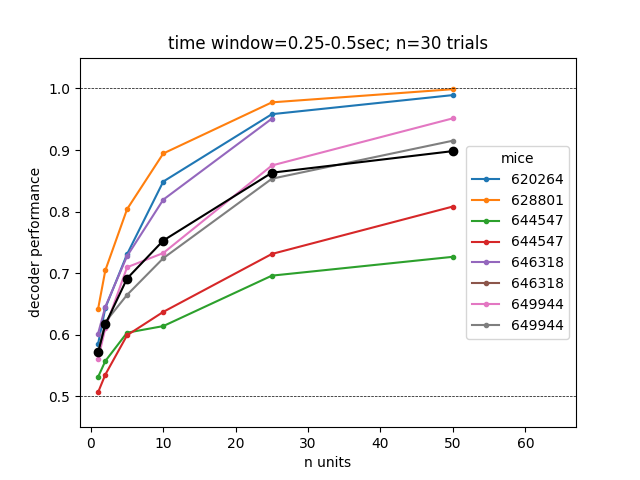

Text(0.5, 1.0, 'time window=0.25-0.5sec; n=30 trials')

In [24]:
sel_t_point=3
sel_n_trials=4

fig,ax=plt.subplots(1,1)

for xx in incl_sessions:
    ax.plot(svc_params['n_units'],decoder_acc_session_mean[sel_t_point][sel_n_trials,:,xx],'.-')
    
ax.plot(svc_params['n_units'],np.nanmean(decoder_acc_session_mean[sel_t_point][sel_n_trials,:,incl_sessions],0),'ko-')

ax.axhline(0.5,color='k',linestyle='--',linewidth=0.5)
ax.axhline(1,color='k',linestyle='--',linewidth=0.5)

ax.set_xlabel('n units')
ax.set_xlim([-1.5,svc_params['n_units'][-1]+17])
ax.set_ylabel('decoder performance')
ax.set_ylim([0.45,1.05])
ax.legend(mouseIDs[incl_sessions],title='mice')

ax.set_title('decoder performance across sessions')

ax.set_title('time window='+str(svc_params['time_bins'][sel_t_point])+
             '-'+str(svc_params['time_bins'][sel_t_point+1])+
             'sec; n='+str(svc_params['trial_number'][sel_n_trials])+' trials')

<IPython.core.display.Javascript object>


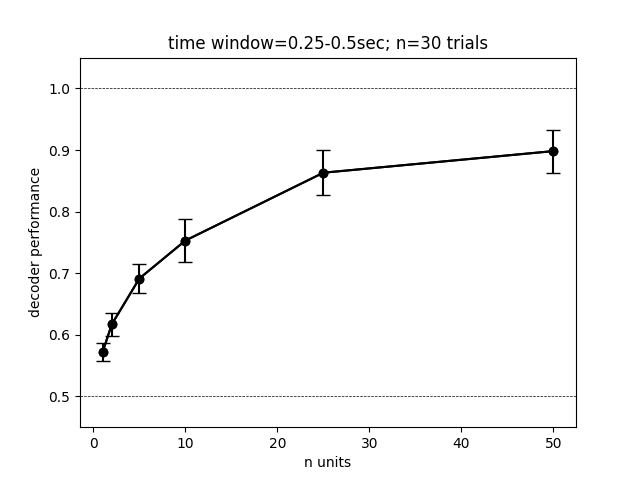

Text(0.5, 1.0, 'time window=0.25-0.5sec; n=30 trials')

In [25]:
sel_t_point=3
sel_n_trials=4

fig,ax=plt.subplots(1,1)

ax.plot(svc_params['n_units'],np.nanmean(decoder_acc_session_mean[sel_t_point][sel_n_trials,:,incl_sessions],0),'ko-')

yvals=np.nanmean(decoder_acc_session_mean[sel_t_point][sel_n_trials,:,incl_sessions],0)
errvals=np.nanstd(decoder_acc_session_mean[sel_t_point][sel_n_trials,:,incl_sessions],0)/np.sqrt(len(incl_sessions))

ax.errorbar(svc_params['n_units'],yvals,errvals,color='k',marker='o',capsize=5)

ax.axhline(0.5,color='k',linestyle='--',linewidth=0.5)
ax.axhline(1,color='k',linestyle='--',linewidth=0.5)

ax.set_xlabel('n units')
ax.set_ylabel('decoder performance')
ax.set_ylim([0.45,1.05])

ax.set_title('decoder performance across sessions')

ax.set_title('time window='+str(svc_params['time_bins'][sel_t_point])+
             '-'+str(svc_params['time_bins'][sel_t_point+1])+
             'sec; n='+str(svc_params['trial_number'][sel_n_trials])+' trials')

<IPython.core.display.Javascript object>


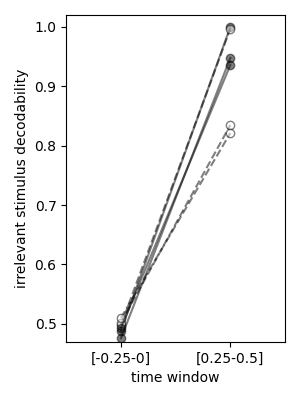

In [27]:
# plot prestim vs. stim decoder performance across sessions @ max units & trials
sel_t_points=[0,2]
sel_n_trials=6
sel_n_units=5

prestim=decoder_acc_session_mean[sel_t_points[0]][sel_n_trials,sel_n_units,incl_sessions]
stim=decoder_acc_session_mean[sel_t_points[1]][sel_n_trials,sel_n_units,incl_sessions]

temp_modality=np.asarray(modality)
temp_modality=temp_modality[incl_sessions]

fig,ax=plt.subplots(1,1,figsize=(3,4))
for xx in range(0,len(incl_sessions)):
    if temp_modality[xx]=='aud':
        face_color='k'
        line_style='-'
    elif temp_modality[xx]=='vis':
        face_color='white'
        line_style='--'
    ax.plot([0,1],[prestim[xx],stim[xx]],'ko',markerfacecolor=face_color,linestyle=line_style,alpha=0.5)
    
ax.set_ylim([0.47,1.02])
ax.set_xlim([-0.5,1.5])

ax.set_xticks([0,1])
ax.set_xticklabels(['[-0.25-0]','[0.25-0.5]'])
ax.set_xlabel('time window')
ax.set_ylabel('irrelevant stimulus decodability')

fig.tight_layout()

In [28]:
# find stdev of sessions @ 25units and 30 trials
sel_t_point=3
sel_n_trials=4
sel_n_units=4

decoder_std=np.nanstd(decoder_acc_session_mean[sel_t_point][sel_n_trials,sel_n_units,incl_sessions])

print('decoder std = ',decoder_std)

decoder std =  0.1037291845007506


In [29]:
# pooled stdev assuming same stdev for Sensory and PFC:
# s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

sel_t_point=3
sel_n_trials=4
sel_n_units=4

#variance of decodability - assume same for sensory and pfc
var1 = np.nanvar(decoder_acc_session_mean[sel_t_point][sel_n_trials,sel_n_units,incl_sessions])

pooled_stdev = np.sqrt(((len(incl_sessions)-1)*var1 + (len(incl_sessions)-1)*var1) / (len(incl_sessions)*2-2))
pooled_stdev

0.1037291845007506

In [ ]:
# d = (u1 - u2) / s

In [42]:
# import required modules
from math import sqrt
from statsmodels.stats.power import TTestIndPower
  
#calculation of effect size
# size of samples in pilot study
n1, n2 = len(incl_sessions), len(incl_sessions)
  
# variance of samples in pilot study
s1 = np.nanvar(decoder_acc_session_mean[sel_t_point][sel_n_trials,sel_n_units,incl_sessions])
s2 = np.nanvar(decoder_acc_session_mean[sel_t_point][sel_n_trials,sel_n_units,incl_sessions])
  
# calculate the pooled standard deviation 
# (Cohen's d)
s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

# means of the samples
u1 = np.nanmean(decoder_acc_session_mean[sel_t_point][sel_n_trials,sel_n_units,incl_sessions])
u2 = u1 - 0.1
    
# calculate the effect size
d = (u1 - u2) / s
print(f'Effect size: {d}')
  
# factors for power analysis
alpha = 0.05
power = 0.8
  
# perform power analysis to find sample size 
# for given effect
obj = TTestIndPower()
n = obj.solve_power(effect_size=d, alpha=alpha, power=power, 
                    ratio=1, alternative='two-sided')
  
print('Sample size/Number needed in each group: {:.3f}'.format(n))

Effect size: 0.9640488400762118
Sample size/Number needed in each group: 17.903


In [ ]:
s

In [ ]:
n

In [35]:
# import required modules
from math import sqrt
from statsmodels.stats.power import TTestIndPower
  
#calculation of effect size
# size of samples in pilot study
n1, n2 = len(incl_sessions), len(incl_sessions)
  
# variance of samples in pilot study
s1 = np.nanvar(decoder_acc_session_mean[sel_t_point][sel_n_trials,sel_n_units,incl_sessions])
s2 = np.nanvar(decoder_acc_session_mean[sel_t_point][sel_n_trials,sel_n_units,incl_sessions])
  
# calculate the pooled standard deviation 
# (Cohen's d)
s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

# mean_diff=np.asarray([0.05,0.1,0.2,0.3,0.5])
mean_diff=np.arange(0.05,0.5,0.005)
cohen_d=np.zeros(len(mean_diff))
N_req=np.zeros(len(mean_diff))

for im,mm in enumerate(mean_diff):
    # means of the samples
    u1 = np.nanmean(decoder_acc_session_mean[sel_t_point][sel_n_trials,sel_n_units,incl_sessions])
    u2 = u1 - mm

    # calculate the effect size
    d = (u1 - u2) / s
    print(f'Mean diff: {mm}')
    print(f'Effect size: {d}')
    cohen_d[im]=d
    
    # factors for power analysis
    alpha = 0.05
    power = 0.8

    # perform power analysis to find sample size 
    # for given effect
    obj = TTestIndPower()
    n = obj.solve_power(effect_size=d, alpha=alpha, power=power, 
                        ratio=1, alternative='two-sided')
    print('Sample size/Number needed in each group: {:.3f}'.format(n))
    print(' ')
    N_req[im]=n

Mean diff: 0.05
Effect size: 0.4820244200381064
Sample size/Number needed in each group: 68.535
 
Mean diff: 0.055
Effect size: 0.530226862041917
Sample size/Number needed in each group: 56.812
 
Mean diff: 0.06
Effect size: 0.5784293040457277
Sample size/Number needed in each group: 47.897
 
Mean diff: 0.065
Effect size: 0.6266317460495373
Sample size/Number needed in each group: 40.960
 
Mean diff: 0.06999999999999999
Effect size: 0.6748341880533479
Sample size/Number needed in each group: 35.457
 
Mean diff: 0.07499999999999998
Effect size: 0.7230366300571586
Sample size/Number needed in each group: 31.018
 
Mean diff: 0.07999999999999999
Effect size: 0.7712390720609692
Sample size/Number needed in each group: 27.385
 
Mean diff: 0.08499999999999999
Effect size: 0.8194415140647798
Sample size/Number needed in each group: 24.376
 
Mean diff: 0.08999999999999998
Effect size: 0.8676439560685905
Sample size/Number needed in each group: 21.856
 
Mean diff: 0.09499999999999997
Effect size

Sample size/Number needed in each group: 2.193
 
Mean diff: 0.48999999999999977
Effect size: 4.723839316373437
Sample size/Number needed in each group: 2.181
 
Mean diff: 0.4949999999999998
Effect size: 4.772041758377247
Sample size/Number needed in each group: 2.169
 


In [36]:
u1

0.8631334124821057

<IPython.core.display.Javascript object>


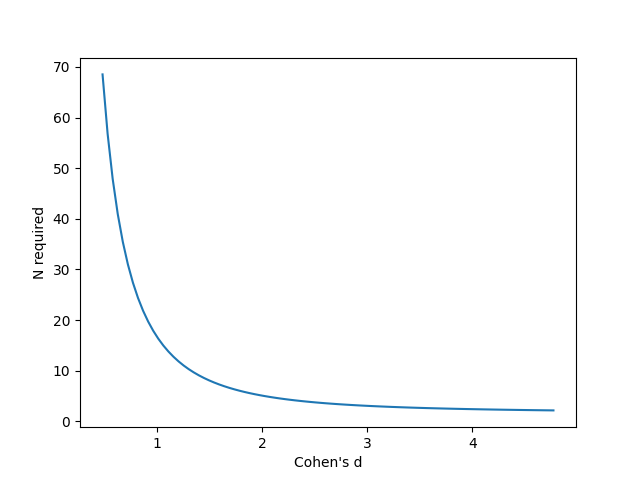

Text(0, 0.5, 'N required')

In [37]:
fig,ax=plt.subplots(1,1)

ax.plot(cohen_d,N_req)

ax.set_xlabel("Cohen's d")
ax.set_ylabel('N required')

<IPython.core.display.Javascript object>


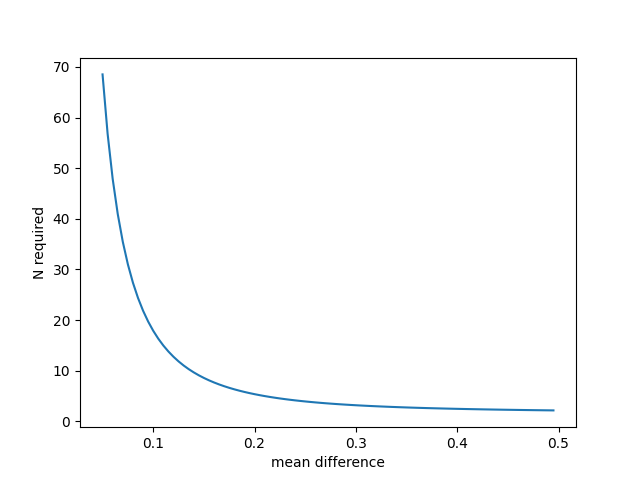

Text(0, 0.5, 'N required')

In [38]:
fig,ax=plt.subplots(1,1)

ax.plot(mean_diff,N_req)

ax.set_xlabel("mean difference")
ax.set_ylabel('N required')